# Step 1: Load Images

In [1]:
from PIL import Image
import os

def load_image(image_path):
    """
    Load an image from the given path and return it.
    If an image is grayscale, convert it to RGB
    """
    
    return Image.open(image_path).convert('RGB')


# Step 2: Preprocess Images

In [2]:
import torchvision.transforms as transforms

def preprocess_image(img):
    """
    Preprocess the given image to the format required by the model.
    """
    
    # Define the image transformations (resize, center crop, and normalization)
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = preprocess(img)
    
    return img.unsqueeze(0)


c:\Users\ktumm\anaconda3\envs\big_data\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
image1_tensor = preprocess_image(load_image(r"D:\data\image_data\coco2017_train\train2017\000000147328.jpg"))
image2_tensor = preprocess_image(load_image(r"D:\data\image_data\coco2017_train\train2017\000000414738.jpg"))
print(image1_tensor)

tensor([[[[ 1.7523,  1.5297,  1.6838,  ..., -0.5767, -0.4568, -0.5253],
          [ 0.7762,  0.7077,  0.5022,  ..., -0.5424, -0.5253, -0.9877],
          [ 0.3309, -0.1314,  0.1426,  ..., -0.2856, -0.8678, -1.1760],
          ...,
          [ 0.9817,  0.9132,  0.9132,  ..., -1.1932, -1.2274, -1.2445],
          [ 0.9132,  0.8447,  0.8447,  ..., -0.8507, -0.9363, -0.9534],
          [ 0.8276,  0.7248,  0.7762,  ...,  0.3138,  0.1768,  0.1597]],

         [[ 1.9559,  1.7283,  1.9209,  ..., -0.2325, -0.1275, -0.2325],
          [ 1.0455,  1.0105,  0.8004,  ..., -0.2325, -0.2325, -0.7227],
          [ 0.5203,  0.1527,  0.4503,  ..., -0.0924, -0.6176, -0.8803],
          ...,
          [ 1.5182,  1.4832,  1.4832,  ..., -0.7927, -0.8277, -0.8102],
          [ 1.4482,  1.4307,  1.3957,  ..., -0.3725, -0.4601, -0.4951],
          [ 1.3606,  1.2906,  1.3081,  ...,  0.9580,  0.8179,  0.7654]],

         [[ 1.9428,  1.7337,  1.6814,  ..., -0.8807, -0.8633, -1.0201],
          [ 0.7228,  0.6879, -

In [12]:
import matplotlib.pyplot as plt
import torch

def show_image(image_tensor):
    """
    Display a tensor image after reversing the normalization.
    """
    # Reverse the normalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    image_tensor = image_tensor.clone()  # Clone to avoid modifying the original tensor
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    
    # Remove the batch dimension if it exists
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)
        
    # Convert tensor to PIL image
    image_tensor = torch.clamp(image_tensor, 0, 1)  # Ensure the values are within [0, 1]
    image_pil = transforms.ToPILImage()(image_tensor)
    
    # Display the image
    plt.imshow(image_pil)
    plt.axis('off')  # Hide the axis
    plt.show()


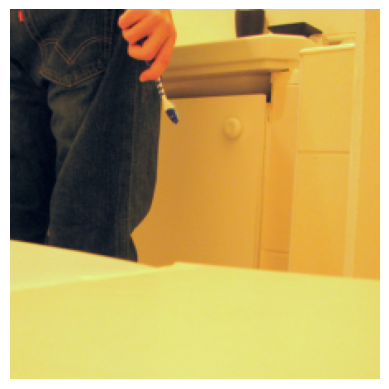

In [14]:
show_image(image2_tensor)

# Part 3: Extract Embeddings

In [5]:
import torch
import torchvision.models as models

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
# Remove the final classification layer
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Set the model to evaluation mode
model.eval()

def extract_embedding(image_tensor):
    """
    Extract the embedding of an image tensor using the pre-trained model.
    """
    with torch.no_grad():
        embedding = model(image_tensor.unsqueeze(0))
    return embedding.squeeze()


c:\Users\ktumm\anaconda3\envs\big_data\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ktumm\anaconda3\envs\big_data\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
embedding2 = extract_embedding(image2_tensor)
embedding1 = extract_embedding(image1_tensor)
print(embedding1.shape)

torch.Size([2048])


# Step 4: Compute Similarity

In [9]:
import torch.nn.functional as F

def compute_cosine_similarity(embedding1, embedding2):
    """
    Compute the cosine similarity between two embeddings.
    """
    return F.cosine_similarity(embedding1, embedding2, dim=0)


In [10]:
compute_cosine_similarity(embedding1, embedding2)

tensor(0.6895)

In [11]:
def image_similarity(image_path1, image_path2):
    """
    Compute the similarity between two images given their paths.
    """
    # Load and preprocess images
    image1 = load_image(image_path1)
    image2 = load_image(image_path2)
    
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)
    
    # Extract embeddings
    embedding1 = extract_embedding(image1)
    embedding2 = extract_embedding(image2)
    
    # Compute similarity
    similarity = compute_cosine_similarity(embedding1, embedding2)
    
    return similarity.item()

# Example usage:
# similarity = image_similarity("path/to/image1.jpg", "path/to/image2.jpg")
# print(f"Similarity: {similarity}")


In [12]:
image_similarity("000000166598.jpg", "000000414738.jpg")


0.6895161271095276